In [1]:
import json
import polars as pl
import torch
from tqdm import tqdm
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

seed_val = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)

In [2]:
with open("./params.json", mode = "r", encoding = "utf-8") as f:
    data = json.load(f)
    model_path = data["model_path"]
    num_single_sample_timesteps = data["num_single_sample_timesteps"]
    input_window_length = data["input_window_length"]
    input_features = data["input_features"]
    label_features = data["label_features"]

    # Usually window_stride = 1 since we want to check each input window
    window_stride = 20

In [3]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, max_len):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [4]:
class TimeSeriesTransformer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, d_model, num_head, num_encoder_layers, num_decoder_layers, positional_encoding_max_len, position_wise_ffn_dim, dropout):
        super().__init__()
        self.input_proj = torch.nn.Linear(input_dim, d_model)
        self.output_proj = torch.nn.Linear(output_dim, d_model)
        
        self.pos_encoder = PositionalEncoding(
            d_model = d_model,
            dropout = dropout,
            max_len = positional_encoding_max_len
        )

        self.transformer = torch.nn.Transformer(
            d_model = d_model,
            nhead = num_head,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dropout = dropout,
            dim_feedforward = position_wise_ffn_dim,
            batch_first = True
        )

        self.final_proj = torch.nn.Linear(d_model, output_dim)

        # Multi-head Self-Attention
        self.attention_weights = {
            "encoder_attention": [],
            "decoder_attention": [],
            "encoder_decoder_attention": []
        }
        self._register_attention_hooks()

    def _register_attention_hooks(self):
        self.attention_weights = {
            "encoder_attention": [],
            "decoder_attention": [],
            "encoder_decoder_attention": []
        }

        # They are all multi-head self-attentions --> The naming convention is different
        for layer in self.transformer.encoder.layers:
            self._patch_multi_head_attetion(layer.self_attn, "encoder_attention")

        for layer in self.transformer.decoder.layers:
            self._patch_multi_head_attetion(layer.self_attn, "decoder_attention")
            self._patch_multi_head_attetion(layer.multihead_attn, "encoder_decoder_attention")

    def _patch_multi_head_attetion(self, mha_module, attn_type):
        '''
            We have a saved transformer model that did not have the attention tracking
            The goal here is to patch the forward method in the trained transformer model so that it proceeds normally but also tracks attentions.
            That's why we are assigning a function to the forward method 
        '''
        original_forward = mha_module.forward

        def new_forward(*args, **kwargs):
            # Two lines combined together will return each attention head not averaged across all heads!
            kwargs["need_weights"] = True
            kwargs["average_attn_weights"] = False

            attn_output, attn_output_weights = original_forward(*args, **kwargs)
            self.attention_weights[attn_type].append(attn_output_weights)

            return attn_output, attn_output_weights

        # Replace the forward method with our patched version
        mha_module.forward = new_forward

    def forward(self, src, tgt, tgt_mask = None):
        for key in self.attention_weights.keys():
            self.attention_weights[key].clear()

        src = self.input_proj(src)
        src = self.pos_encoder(src)
        
        tgt = self.output_proj(tgt)
        tgt = self.pos_encoder(tgt)
        
        if(tgt_mask is None):
            tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)

        decoder_out = self.transformer(src, tgt, tgt_mask = tgt_mask)

        return self.final_proj(decoder_out)

In [5]:
df = pl.read_csv("./reversalData_minor.csv")
df = df.drop(["id", "eps", "n_0_squared"])
df = df.select(
    pl.col("*").str.json_decode()
)
df = df.with_columns(
    eta_list = pl.col("eta_list").list.eval(pl.element().flatten(), parallel = True)
)
df = df.sample(n = len(df), with_replacement = False, shuffle = True, seed = seed_val)

In [6]:
df_test = df[int(len(df) * 0.9):]

In [7]:
# All-in-one-go

# df_test = df_test.select(
#     (pl.col("*") - pl.col("*").list.mean()) / pl.col("*").list.std()
# )

In [8]:
# def createPredictionWindows(dataframe, stride, input_features, input_window_length, label_features):
#     """
#         Creates predictions windows where input_window moves by stride and the label window is the all remaining timesteps

#         dataframe: In time-series format where columns are features and rows are time-series steps (Polars exploded format!)
#         stride: How many timesteps will input_window move by.
#         input_features: Names of the input features in a list
#         input_window_length: Input window size in timesteps
#         label_features: Names of the label features in a list
#     """

#     input_df = dataframe.select(
#         pl.col(input_features)
#     )
#     input_df = input_df.select(
#         numbers = pl.concat_list("*")   # List of all features
#     )
#     input_df = input_df[:-1].with_row_index("index").with_columns(    # Exluding last timestep which will be min label window length
#         pl.col("index").cast(pl.Int64)
#     )
#     input_df = input_df.group_by_dynamic(   # index is considered for grouping
#         index_column = "index",
#         period = f"{input_window_length}i",
#         every = f"{stride}i",
#         closed = "left"
#     ).agg(
#         pl.col("numbers").alias("X"),
#         pl.len().alias("seq_len")
#     )
#     input_df = input_df.filter(
#         pl.col("seq_len") == input_window_length
#     )
#     input_df = input_df.select(
#         pl.exclude(["index", "seq_len"])
#     )


#     label_df = dataframe.select(
#         pl.col(label_features)
#     )
#     label_df = label_df.select(
#         numbers = pl.concat_list("*")
#     )
#     label_df = label_df[input_window_length:].with_row_index("index").with_columns(
#         pl.col("index").cast(pl.Int64)
#     )
#     label_df = label_df.group_by_dynamic(
#         index_column = "index",
#         period = f"{num_single_sample_timesteps - input_window_length}i",
#         every = f"{stride}i",
#         closed = "left"
#     ).agg(
#         pl.col("numbers").alias("Y")    # Removing the seq_len check will handle our goal!
#     )
#     label_df = label_df.select(
#         pl.exclude(["index"])
#     )

#     return pl.concat([input_df, label_df], how = "horizontal")    

In [9]:
# All-in-one-go

# df_test = df_test.explode("*")

# timeseries_df_test = pl.DataFrame()

# for i in range(0, len(df_test), num_single_sample_timesteps):
#     temp_df = createPredictionWindows(
#         dataframe = df_test[i:i + num_single_sample_timesteps],
#         stride = 1,
#         input_features = input_features,
#         input_window_length = input_window_length,
#         label_features = label_features
#     )

#     if(temp_df.is_empty()):
#         timeseries_df_test = temp_df
#     else:
#         timeseries_df_test = pl.concat([timeseries_df_test, temp_df], how = "vertical")

# timeseries_df_test

In [10]:
# All-in-one-go

# df_test = timeseries_df_test

# %reset_selective -f "^timeseries_df_test$"
# %reset_selective -f "^df$"

## On-Demand Data Loading

In [11]:
class WindowedDataset(Dataset):
    def __init__(self, input_df, label_df, num_single_sample_timesteps, stride, input_window_length):
        # The label window is whatever comes after input window --> We want to let it just predict into the future
        # Autoregressive inference so no problem!
        
        super().__init__()
        
        self.input_df = input_df  # Type: Numpy, Shape: Number of time-series, Number of time-steps, Number of input features
        self.label_df = label_df  # Type: Numpy, Shape: Number of time-series, Number of time-steps, Number of label features
        self.num_single_sample_timesteps = num_single_sample_timesteps
        self.stride = stride
        self.input_window_length = input_window_length
        
        self.window_indices = []
        for time_series_idx in range(self.input_df.shape[0]):
            for input_window_start_idx in range(0, self.input_df.shape[1] - self.input_window_length, self.stride):
                self.window_indices.append((time_series_idx, input_window_start_idx))

    def __len__(self):
        return len(self.window_indices)
    
    def __getitem__(self, index):
        time_series_idx, input_window_start_idx = self.window_indices[index]

        label_window_start_idx = input_window_start_idx + self.input_window_length
        input_window = self.input_df[time_series_idx, input_window_start_idx: label_window_start_idx, :]
        label_window = self.label_df[time_series_idx, label_window_start_idx:, :]
        input_labels = self.label_df[time_series_idx, input_window_start_idx: label_window_start_idx, :]

        input_window_mean = input_window.mean(axis = 0)
        input_window_std = input_window.std(axis = 0)
        input_window_std[input_window_std == 0] = 10 ** -8
        input_window = (input_window - input_window_mean) / input_window_std

        input_window = torch.tensor(input_window, dtype = torch.float)
        label_window = torch.tensor(label_window, dtype = torch.float)
        input_labels = torch.tensor(input_labels, dtype = torch.float)

        return input_window, label_window, input_labels

In [12]:
num_test_samples = df_test.shape[0]

input_df = df_test.select(
    pl.col(input_features)
)
label_df = df_test.select(
    pl.col(label_features)
)
input_df = input_df.explode("*").to_numpy()
input_df = input_df.reshape(num_test_samples, num_single_sample_timesteps, len(input_features))
label_df = label_df.explode("*").to_numpy()
label_df = label_df.reshape(num_test_samples, num_single_sample_timesteps, len(label_features))

df_test = WindowedDataset(
    input_df = input_df,
    label_df = label_df,
    num_single_sample_timesteps = num_single_sample_timesteps,
    stride = window_stride,
    input_window_length = input_window_length
)

data_loader_test = DataLoader(
    df_test,
    batch_size = None,  # Architecture expects batched!
    shuffle = False,
    num_workers = 10,
    prefetch_factor = 4,
    persistent_workers = True,
    pin_memory = True
)

## Prediction

In [13]:
model = torch.load(model_path, weights_only = False).to(device)
model._register_attention_hooks()
model.eval()

TimeSeriesTransformer(
  (input_proj): Linear(in_features=7, out_features=32, bias=True)
  (output_proj): Linear(in_features=1, out_features=32, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
     

  0%|          | 0/6000 [00:01<?, ?it/s, single_test_loss=1.900797]

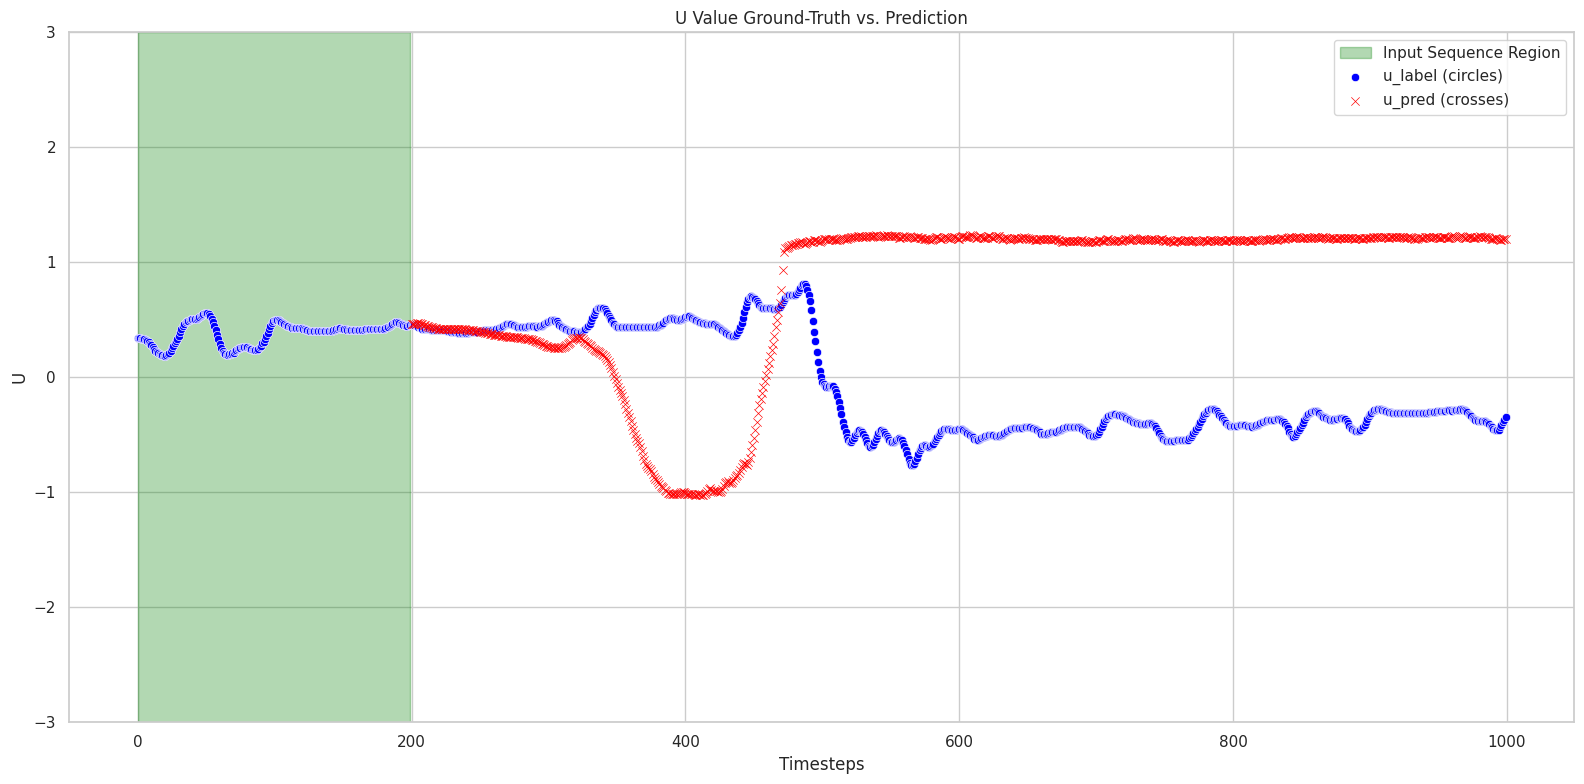

  0%|          | 1/6000 [00:01<3:11:39,  1.92s/it, single_test_loss=1.900797]

Output Timestep 201: Input Timesteps [199 198 200  91  92 183 182 181 184 185] with scores ['0.01056', '0.01010', '0.01004', '0.00953', '0.00951', '0.00923', '0.00922', '0.00919', '0.00917', '0.00915']
Output Timestep 202: Input Timesteps [ 5  6  1  4  2  3 65  7 64 35] with scores ['0.00800', '0.00798', '0.00780', '0.00775', '0.00763', '0.00760', '0.00741', '0.00732', '0.00713', '0.00710']
Output Timestep 203: Input Timesteps [62 61 63 64 60 14 59 15 58  2] with scores ['0.00774', '0.00769', '0.00761', '0.00753', '0.00730', '0.00714', '0.00706', '0.00688', '0.00670', '0.00662']
Output Timestep 204: Input Timesteps [61 62 63 60 64 14 59 15 58 57] with scores ['0.00782', '0.00781', '0.00760', '0.00754', '0.00748', '0.00733', '0.00730', '0.00712', '0.00693', '0.00660']
Output Timestep 205: Input Timesteps [61 62 63 60 64 14 59 15 58 57] with scores ['0.00787', '0.00785', '0.00761', '0.00761', '0.00748', '0.00737', '0.00737', '0.00718', '0.00699', '0.00664']
Output Timestep 206: Input Tim

  0%|          | 10/6000 [00:10<1:21:54,  1.22it/s, single_test_loss=1.483635]

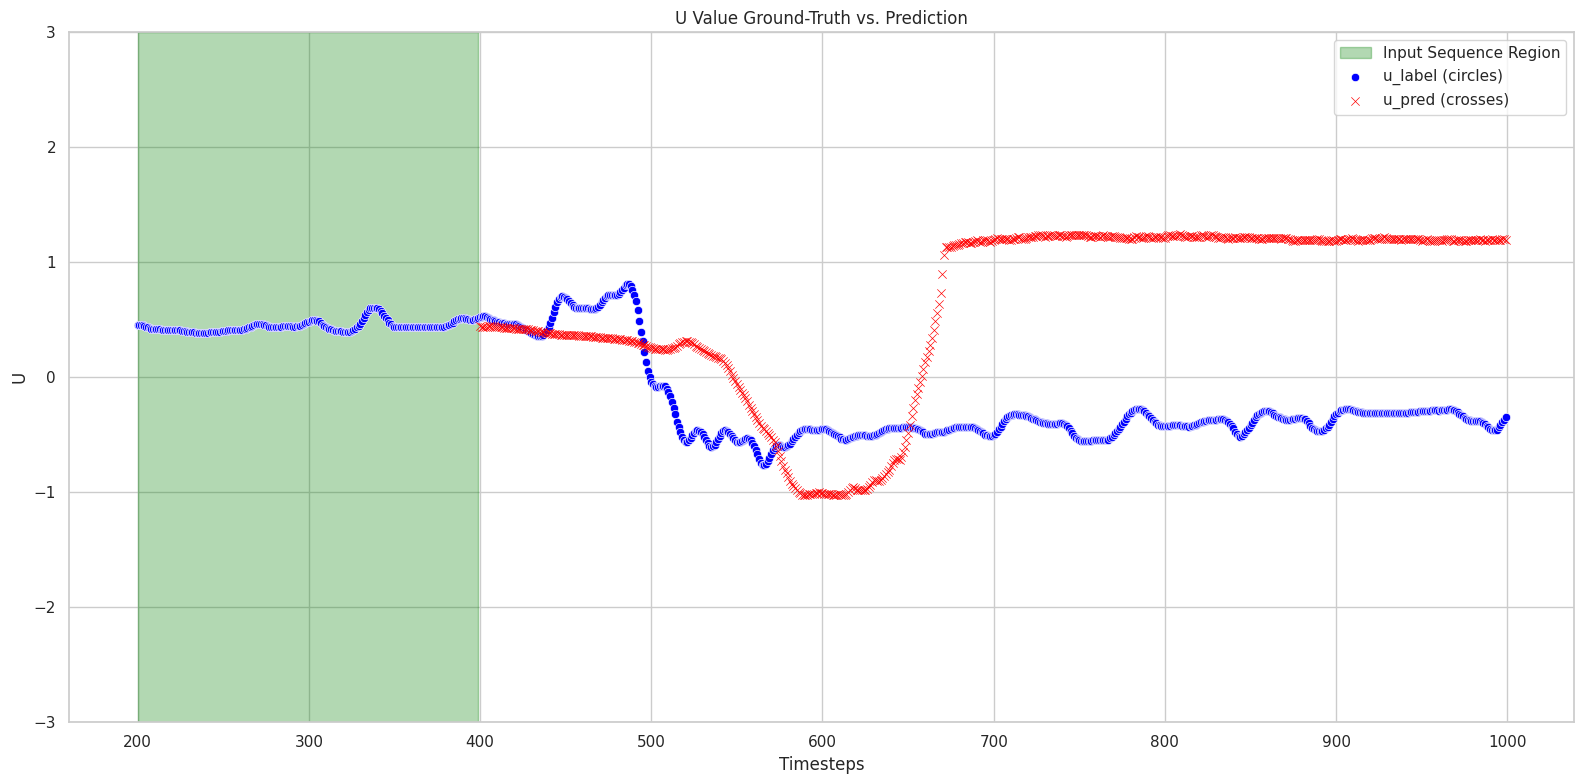

  0%|          | 11/6000 [00:10<1:23:29,  1.20it/s, single_test_loss=1.483635]

Output Timestep 401: Input Timesteps [400 399 385 334 384 382 383 381 386 380] with scores ['0.01318', '0.01253', '0.01116', '0.01107', '0.01100', '0.01097', '0.01089', '0.01087', '0.01080', '0.01047']
Output Timestep 402: Input Timesteps [270 269 271 400 268 202 208 281 399 280] with scores ['0.00737', '0.00731', '0.00729', '0.00728', '0.00704', '0.00694', '0.00690', '0.00683', '0.00683', '0.00681']
Output Timestep 403: Input Timesteps [274 273 275 214 215 276 278 279 277 230] with scores ['0.00678', '0.00672', '0.00672', '0.00665', '0.00665', '0.00663', '0.00663', '0.00662', '0.00662', '0.00659']
Output Timestep 404: Input Timesteps [273 274 311 275 312 276 229 309 230 310] with scores ['0.00713', '0.00712', '0.00693', '0.00691', '0.00687', '0.00682', '0.00676', '0.00676', '0.00676', '0.00676']
Output Timestep 405: Input Timesteps [273 274 311 312 275 310 276 309 243 229] with scores ['0.00728', '0.00724', '0.00706', '0.00697', '0.00696', '0.00690', '0.00687', '0.00686', '0.00685', '

  0%|          | 20/6000 [00:16<56:30,  1.76it/s, single_test_loss=0.255958]  

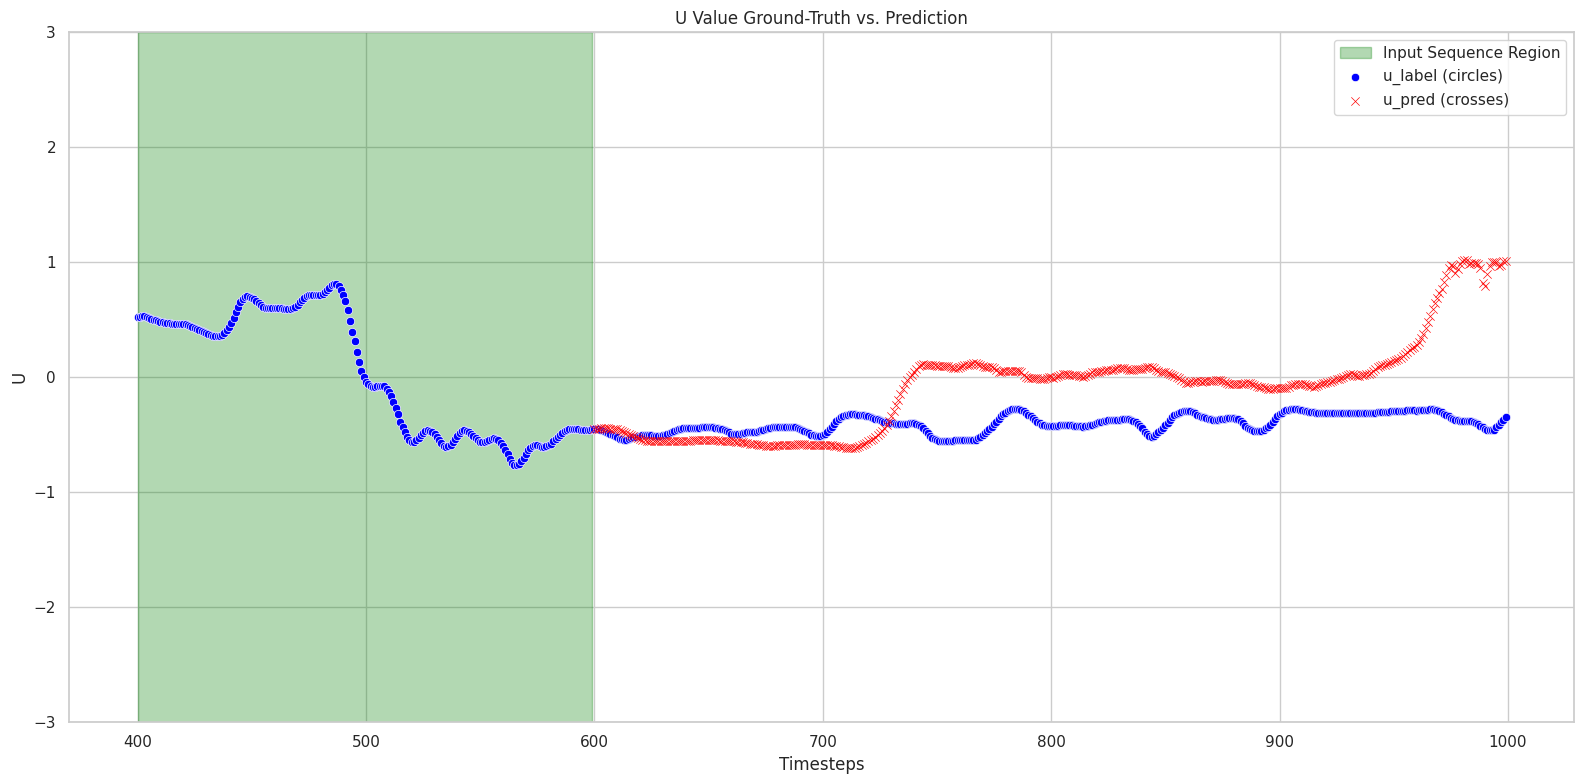

  0%|          | 21/6000 [00:16<58:05,  1.72it/s, single_test_loss=0.255958]

Output Timestep 601: Input Timesteps [589 590 588 591 587 599 592 541 540 539] with scores ['0.01565', '0.01437', '0.01371', '0.01280', '0.01225', '0.01090', '0.01080', '0.01077', '0.01070', '0.01039']
Output Timestep 602: Input Timesteps [599 600 541 507 542 508 540 506 509 571] with scores ['0.01010', '0.00985', '0.00958', '0.00953', '0.00946', '0.00946', '0.00941', '0.00937', '0.00934', '0.00924']
Output Timestep 603: Input Timesteps [488 572 542 549 541 571 573 543 540 433] with scores ['0.00695', '0.00693', '0.00689', '0.00689', '0.00689', '0.00686', '0.00684', '0.00683', '0.00681', '0.00681']
Output Timestep 604: Input Timesteps [488 549 435 433 489 434 487 436 550 490] with scores ['0.00765', '0.00746', '0.00715', '0.00713', '0.00711', '0.00707', '0.00698', '0.00695', '0.00682', '0.00678']
Output Timestep 605: Input Timesteps [488 549 435 489 433 434 436 487 550 490] with scores ['0.00775', '0.00760', '0.00726', '0.00721', '0.00721', '0.00716', '0.00708', '0.00705', '0.00699', '

  0%|          | 30/6000 [00:20<32:27,  3.07it/s, single_test_loss=0.071758]

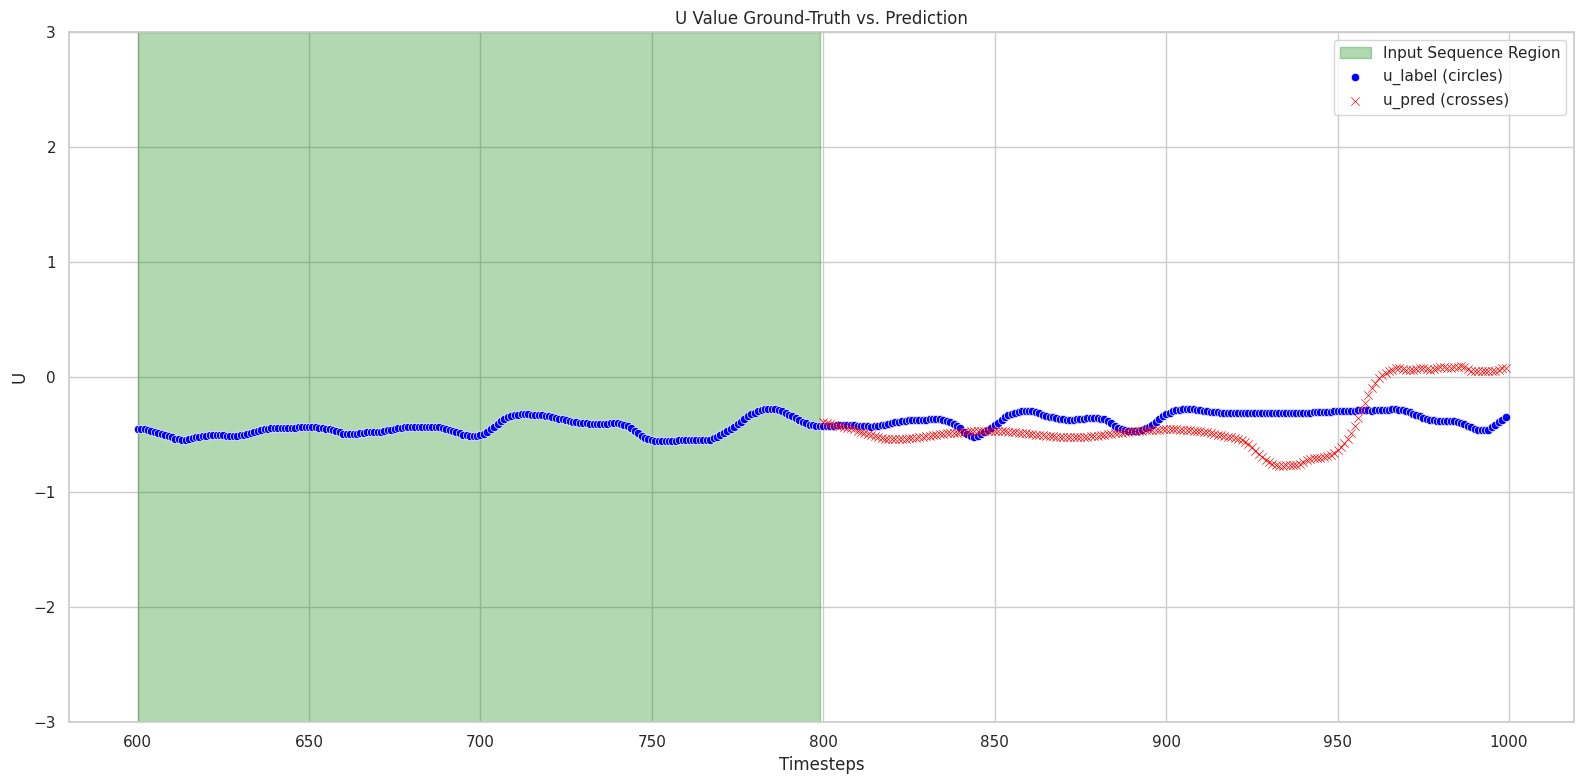

  1%|          | 31/6000 [00:20<34:23,  2.89it/s, single_test_loss=0.071758]

Output Timestep 801: Input Timesteps [758 602 773 759 603 601 772 761 760 604] with scores ['0.01052', '0.01034', '0.01021', '0.01016', '0.00990', '0.00959', '0.00950', '0.00923', '0.00917', '0.00908']
Output Timestep 802: Input Timesteps [773 774 602 775 603 601 772 604 634 635] with scores ['0.00891', '0.00873', '0.00863', '0.00860', '0.00835', '0.00816', '0.00799', '0.00795', '0.00793', '0.00788']
Output Timestep 803: Input Timesteps [645 710 646 712 682 709 647 713 711 650] with scores ['0.00826', '0.00809', '0.00803', '0.00783', '0.00781', '0.00776', '0.00752', '0.00750', '0.00744', '0.00730']
Output Timestep 804: Input Timesteps [712 645 710 709 713 646 711 682 647 648] with scores ['0.00909', '0.00897', '0.00875', '0.00871', '0.00871', '0.00871', '0.00861', '0.00846', '0.00840', '0.00809']
Output Timestep 805: Input Timesteps [712 645 713 709 646 710 711 682 647 648] with scores ['0.00928', '0.00907', '0.00891', '0.00885', '0.00883', '0.00883', '0.00880', '0.00857', '0.00856', '

  1%|          | 40/6000 [00:21<53:12,  1.87it/s, single_test_loss=0.003081]



Single time-series inference done! Stopping inference...


: 

In [ ]:
test_loss = 0.0
# test_progress_bar = tqdm(
#     range(num_single_sample_timesteps - input_window_length)
# )
test_progress_bar = tqdm(
    data_loader_test
)

criterion = torch.nn.MSELoss()
plot_counter = 0

with torch.no_grad():
    for  i, (batch_x, batch_y, x_labels) in enumerate(test_progress_bar):
        # batch_x = torch.Tensor(df_test[i, "X"]).unsqueeze(0).to(device)
        # batch_y = torch.Tensor(df_test[i, "Y"]).unsqueeze(0).to(device)
        if(i == len(range(0, num_single_sample_timesteps - input_window_length, window_stride))):
            print("\n\nSingle time-series inference done! Stopping inference...")
            break
        
        # Since we are not using batches we have to expand first dim so that one data point is considered a batch of size 1
        # Everything expects batches! --> unsqueeze(0) is like expand_dims(axis = 0)
        batch_x = batch_x.unsqueeze(0).to(device)
        batch_y = batch_y.unsqueeze(0).to(device)

        outputs = []
        decoder_input = torch.zeros(batch_y.shape[0], 1, len(label_features)).to(device)
        full_mask = model.transformer.generate_square_subsequent_mask(batch_y.shape[1]).to(device)
        for t in range(batch_y.shape[1]):
            tgt_mask = full_mask[:t + 1, :t + 1]
            out = model(
                batch_x,
                decoder_input,
                tgt_mask = tgt_mask
            )
            next_step = out[:, -1:, :]
            outputs.append(next_step)
            decoder_input = torch.cat([decoder_input, next_step], dim = 1)

        pred = torch.cat(outputs, dim = 1)
        loss = criterion(pred, batch_y)
        test_progress_bar.set_postfix({
            "single_test_loss": f"{loss.item():.6f}"
        })

        if(plot_counter % input_window_length == 0):
            x = list(range(num_single_sample_timesteps))

            u_idx = label_features.index("u_list")

            u_label = batch_y[:, :, u_idx].cpu()[0]
            u_pred = pred[:, :, u_idx].cpu()[0]
            u_x_labels = x_labels[:, u_idx]

            sns.set_theme(style = "whitegrid")
            fig, ax = plt.subplots(figsize = (16, 8))
            ax.set_ylim(-3, 3)

            ax.axvspan(
                x[plot_counter],
                x[plot_counter + input_window_length - 1],
                color = "green",
                alpha = 0.3,
                label = "Input Sequence Region"
            )
            sns.scatterplot(
                x = x[plot_counter : plot_counter + input_window_length],
                y = u_x_labels,
                marker = "o",
                label = "u_label (circles)",
                color = "blue",
                ax = ax
            )
            sns.scatterplot(
                x = x[(input_window_length + plot_counter):],
                y = u_label,
                marker = "o",
                color = "blue",
                ax = ax
            )
            sns.scatterplot(
                x = x[(input_window_length + plot_counter):],
                y = u_pred,
                marker = "x",
                label = "u_pred (crosses)",
                color = "red",
                ax = ax
            )

            ax.set_title("U Value Ground-Truth vs. Prediction")
            ax.set_xlabel("Timesteps")
            ax.set_ylabel("U")
            ax.legend()

            plt.tight_layout()
            plt.show()

            last_decoder_layer_shared_attention = model.attention_weights["encoder_decoder_attention"][-1][0]
            avg_attention_weights = last_decoder_layer_shared_attention.mean(dim = 0).cpu().numpy()

            for i in range(20):     # First 20 predictions following input sequence 
                output_row = avg_attention_weights[i, :]
                top_k_indices = np.argsort(output_row)[::-1][:10]    # Top 10 highest attention input timesteps
                top_k_scores = output_row[top_k_indices]
                print(f"Output Timestep {plot_counter + input_window_length + i + 1}: Input Timesteps {top_k_indices + plot_counter + 1} with scores {[f'{score:.5f}' for score in top_k_scores]}")


        plot_counter += window_stride